In [1]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import time
import util
from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM, Input

import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split


In [2]:

import os

precision = 0.005  # m/z precision for raw data
data_per_sec = 2  # spectrum per second
half_time_window = 30  # time range before and after RT in sec
number_ticks = half_time_window * 2 * data_per_sec  # number of spectrum per data
intensity_treshold = 8000 #  everything under this will be annotated false
number_sample = 120


data_folder = '../data/sara_training/'

try:
    os.mkdir(data_folder)
except:
    pass



peak_clarkii1= data_folder + 'clarkii_peaks.csv' # data with peak: mz, rt, Y/N
mz_clarkii1 = data_folder + 'clarkii_T0I1.mzML'

peak_clarkii10= data_folder + 'AclarkiiT0I10ctrl_peaks.csv' # data with peak: mz, rt, Y/N
mz_clarkii10 = data_folder + 'AclarkiiT0I10ctrl.mzML'

peak_viridis= data_folder + 'viridis_BEHamide_peaks.csv' # data with peak: mz, rt, Y/N
mz_viridis = data_folder + 'viridisT0I2.mzML'

pickle_path = './output/pickle_training.npy'

In [3]:
save_np = False
if save_np == True:

    data_clark1 = util.build_data_ml(peak_clarkii1,mz_clarkii1 )
    data_clark10 = util.build_data_ml(peak_clarkii10,mz_clarkii10, mz_rt_sec=False)
    data_viri = util.build_data_ml(peak_viridis,mz_viridis )

    all_data = [None,None,None,None]
    all_data[0] = data_clark1[0] + data_clark10[0] + data_viri[0]
    all_data[1] = data_clark1[1] + data_clark10[1] +  data_viri[1]
    all_data[2] = data_clark1[2] + data_clark10[2] + data_viri[2]
    all_data[3] = data_clark1[3] + data_clark10[3] + data_viri[3]

    with open(pickle_path, 'wb') as fi:
        np.save(fi, np.asanyarray(data_clark10, dtype=object))
    data = np.load(pickle_path, allow_pickle=True)

else:
    data = np.load(pickle_path, allow_pickle=True)



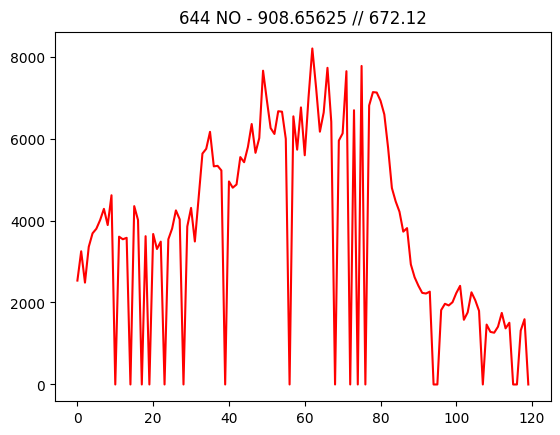

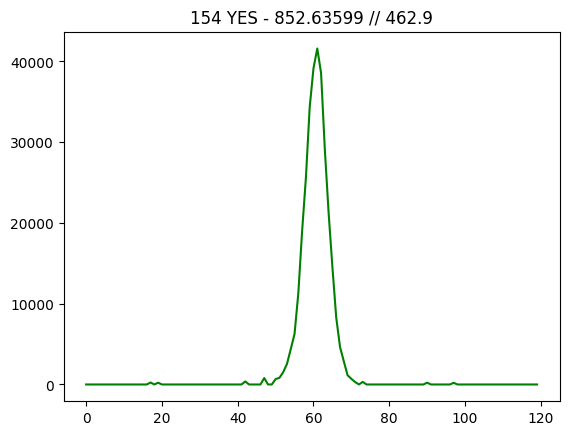

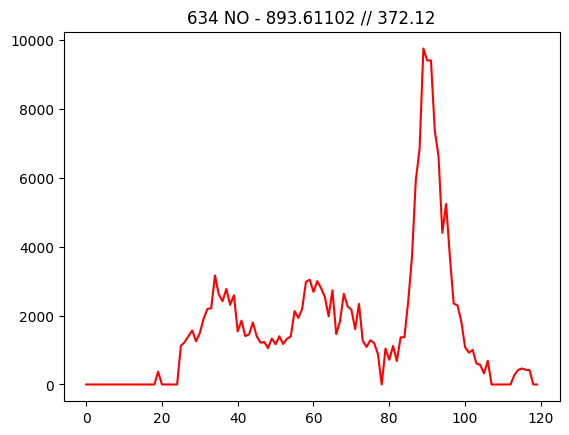

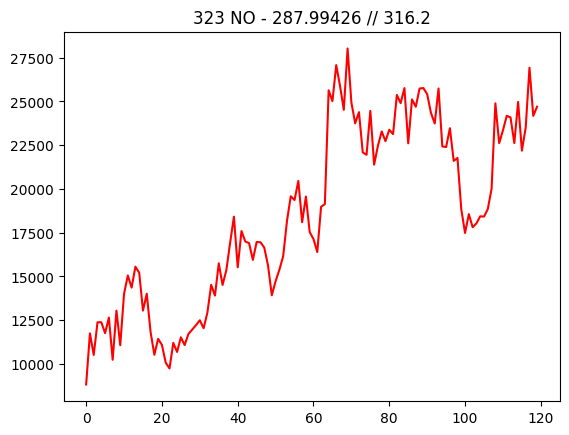

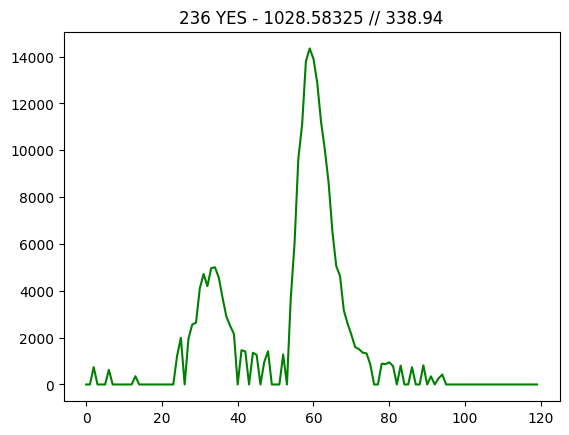

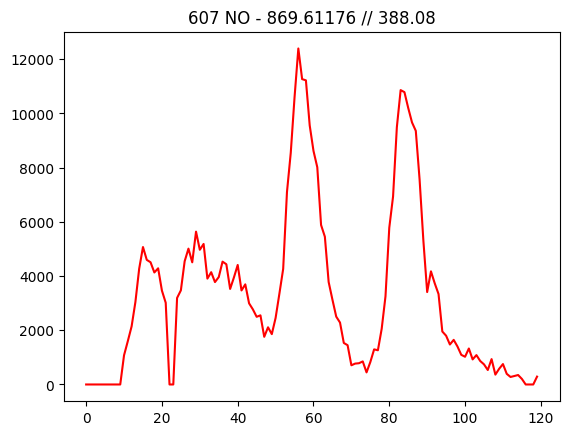

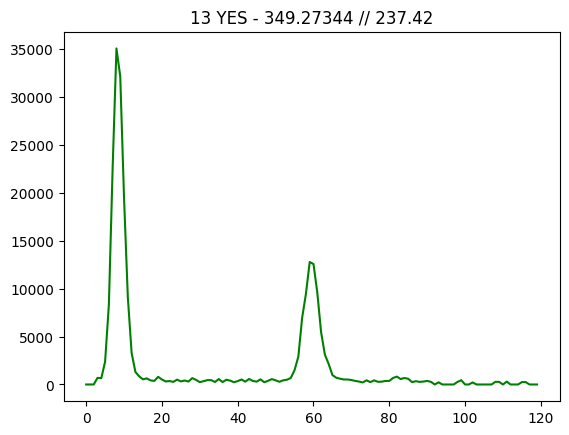

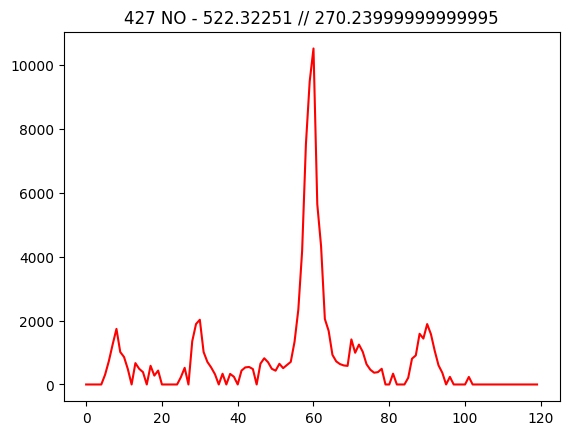

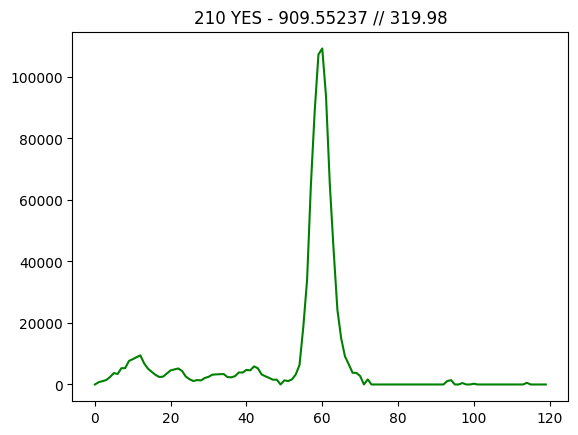

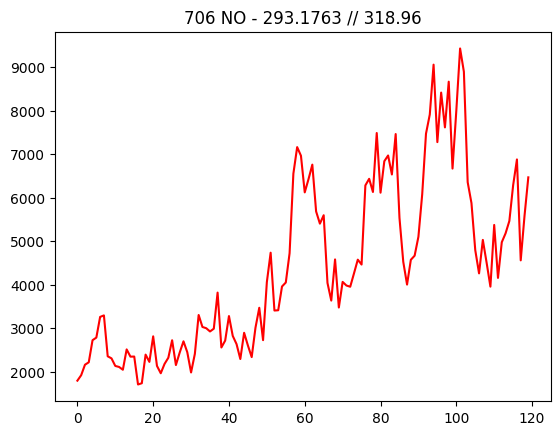

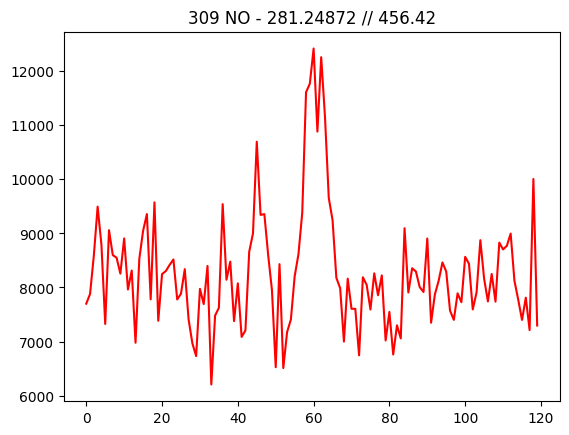

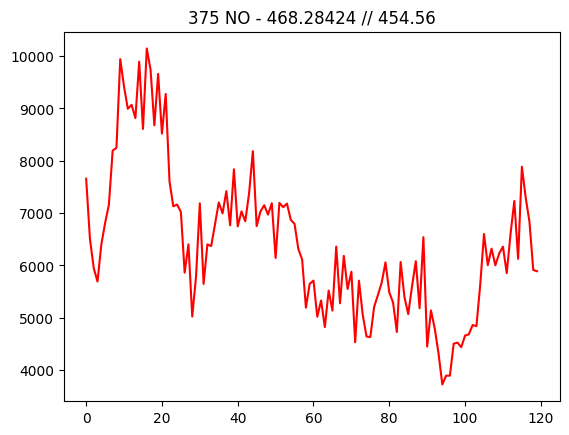

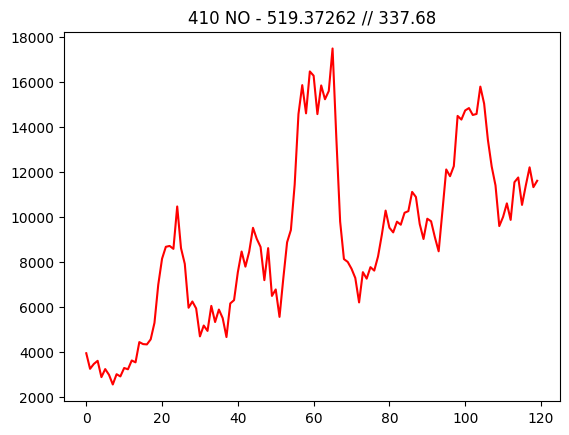

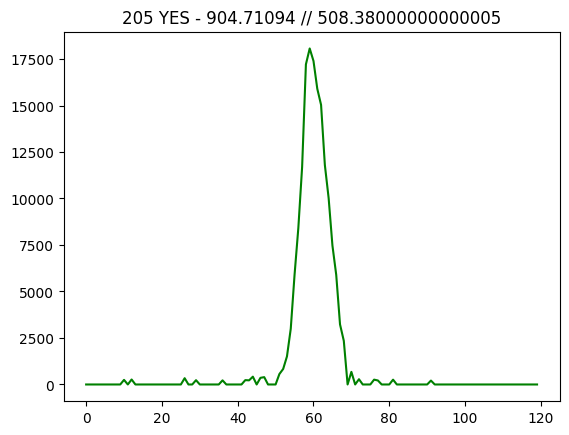

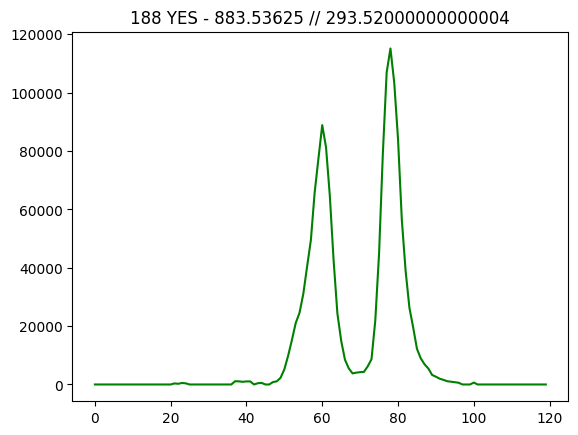

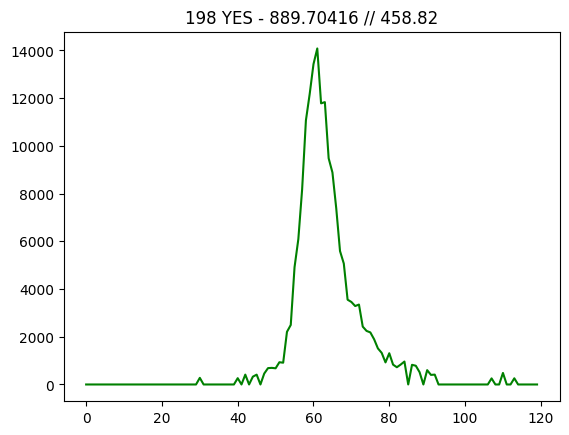

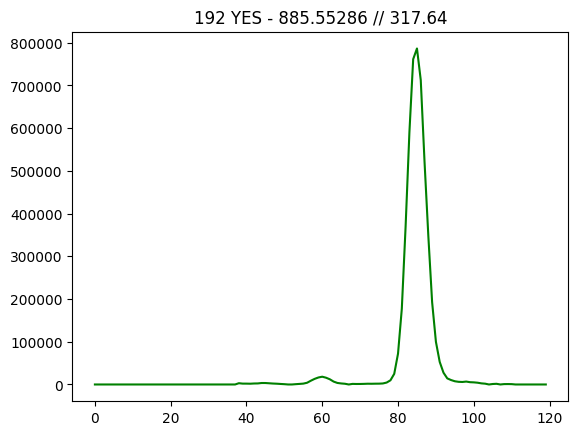

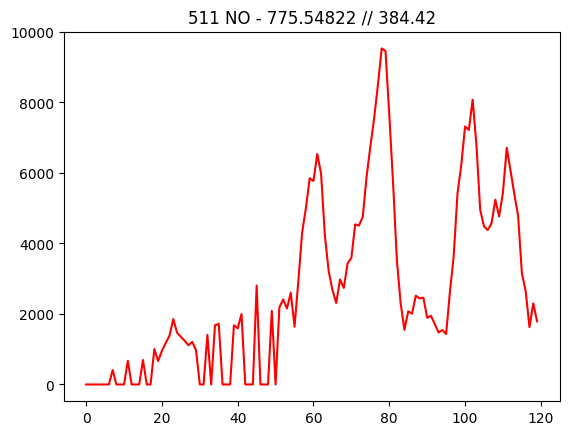

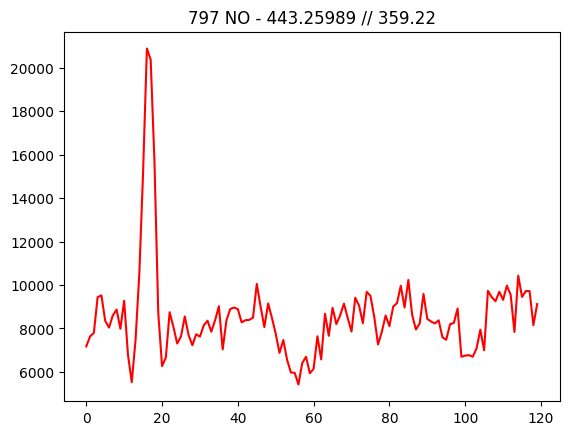

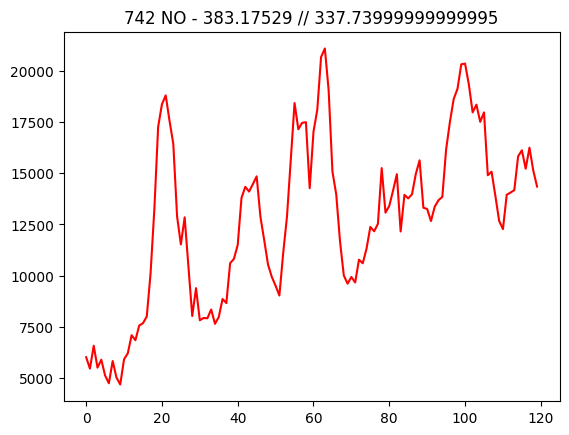

In [4]:


X_ = data[0]
y_ =  data[1]
mz_ = data[2]
rt_ =  data[3]

import random
for i in random.sample(range(0,len(X_)),20):
    color = 'green' if y_[i] == 1 else 'red'
    yn = 'YES' if y_[i] == 1 else 'NO'
    plt.title(  str(i) + ' ' + yn + ' - ' + str(mz_[i]) + ' // ' + str(float(rt_[i])))
    plt.plot(X_[i], color=color)
    plt.show()


In [5]:

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.

    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal

    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)

    see also:

    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter

    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """


    if window_len<3:
        return x


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


def NormalizeData(data):
    if np.max(data) - np.min(data) == 0.0:
        return data
    return (data - np.min(data)) / (np.max(data) - np.min(data))


def getStat(data):
    s = [0, 0, 0, 0, 0]  # nbrObs, mean, var,skew, kurtosis

    if len(data) > 0:
        de = scipy.stats.describe(data)
        s = [de[0]/number_sample, de[2], de[3], de[4], de[5]]

    return np.nan_to_num(np.array(s))


def filter_threshold(values):
    if max(values) >= intensity_treshold:
        return True
    return False



In [6]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
augmentx = 10
my_augmenter = (
     #TimeWarp(n_speed_change=2) * augmentx  # random time warping 5 times in parallel
    #Drift(max_drift=(0.1, 0.5))* augmentx # @ 0.8  # with 80% probability, random drift the signal up to 10% - 50%
     Reverse(prob=.5) * augmentx  # with 50% probability, reverse the sequence
 )


In [7]:
import copy 
xvec =[]
yvec = []
df = pd.DataFrame(X_)
df['y']= y_
df['mz']= mz_
df['rt']= rt_
print(df)
X_aug = my_augmenter.augment(np.vstack(df[0]) )
print(X_aug.shape, X_aug)
for i in range( augmentx):
    yvec.append(y_)
ytotal = np.hstack(yvec)
print(ytotal.shape,ytotal)

                                                     0  y         mz      rt
0    [336.5926, 283.93384, 403.32465, 299.2551, 385...  1  227.20152  149.76
1    [0, 0, 0, 0, 0, 486.59613, 323.1664, 0, 0, 0, ...  1  234.09196   69.12
2    [0, 0, 0, 0, 0, 486.59613, 323.1664, 0, 0, 0, ...  1  234.09196   69.12
3    [552.9305, 517.5925, 376.79205, 246.46094, 377...  1  279.23325  178.68
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  1  299.20129  117.42
..                                                 ... ..        ...     ...
797  [7174.128, 7633.094, 7796.5884, 9442.679, 9524...  0  443.25989  359.22
798  [9330.568, 9545.326, 9141.901, 10190.719, 1108...  0  443.26035   456.9
799  [9056.893, 6974.968, 8470.157, 6691.1694, 7675...  0  443.26047   481.8
800  [5724.94, 5049.97, 5829.6304, 5672.0205, 5941....  0  443.26065   316.5
801  [5967.348, 6016.7505, 6635.265, 6690.4106, 611...  0  443.26071  249.24

[802 rows x 4 columns]
(8020, 120) [[ 681.91967773  670.75250244  683.13006

In [8]:

X_aug = list(X_aug)
df = { i : {'x' : X_aug[i] , 'y': ytotal[i]} for i in range(ytotal.shape[0]) }

df = pd.DataFrame.from_dict(df, orient = 'index')
print(df)

                                                      x  y
0     [681.919677734375, 670.7525024414062, 683.1300...  1
1     [681.919677734375, 670.7525024414062, 683.1300...  1
2     [336.59259033203125, 283.933837890625, 403.324...  1
3     [336.59259033203125, 283.933837890625, 403.324...  1
4     [336.59259033203125, 283.933837890625, 403.324...  1
...                                                 ... ..
8015  [5967.34814453125, 6016.75048828125, 6635.2651...  0
8016  [6943.298828125, 6232.66748046875, 6933.461425...  0
8017  [6943.298828125, 6232.66748046875, 6933.461425...  0
8018  [5967.34814453125, 6016.75048828125, 6635.2651...  0
8019  [6943.298828125, 6232.66748046875, 6933.461425...  0

[8020 rows x 2 columns]


In [9]:


df = df[df['x'].map(lambda  x: filter_threshold(x))]
df['y'] = df['y'].apply(lambda x: 1 if x == True else 0)

df['norm'] = df['x'].apply(lambda x: NormalizeData(x) )



df['smooth'] = df['norm'].apply(lambda x: smooth(x) )
df['smooth'] = df['smooth'].apply(lambda x: x[5:-5] )

df['grad1'] = df['smooth'].apply(lambda x: np.gradient(x) )
df['grad2'] = df['grad1'].apply(lambda x: np.gradient(x) )


# Maxima & Minima
df['maxima'] = df['smooth'].apply(lambda x: scipy.signal.find_peaks(x, width=None, wlen=None, rel_height=0.5, plateau_size=None)[0] )
df['minima'] = df['smooth'].apply(lambda x: scipy.signal.find_peaks(-x, height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)[0] )

df['maxval'] =  df[['smooth', 'maxima']].apply(lambda x: [x.smooth[i] for i in x.maxima], axis=1)
df['minval'] =  df[['smooth', 'minima']].apply(lambda x: [x.smooth[i] for i in x.minima], axis=1)

df['maxvalnorm'] =  df['maxval'].apply(lambda x: NormalizeData(x) if len(x) > 0 else [] )
df['minvalnorm'] =  df['minval'].apply(lambda x: NormalizeData(x) if len(x) > 0 else [] )

# Stats
df['maxvalstats'] =  df['maxvalnorm'].apply(lambda x: getStat(x) )
df['minvalstats'] =  df['minvalnorm'].apply(lambda x: getStat(x) )

df['maximastats'] =  df['maxima'].apply(lambda x: getStat(x) )
df['minimastats'] =  df['minima'].apply(lambda x: getStat(x) )

df['stats'] =  df['smooth'].apply(lambda x: getStat(x) )

df['fft'] = df['x'].apply(lambda x: np.fft.fft(x) )
df['fftr'] = df['fft'].apply(lambda x: np.real(x) )
df['ffti'] = df['fft'].apply(lambda x: np.real(np.imag(x)) )

/var/folders/wn/7gdt_pjn02j1w8_73ql8mp880000gn/T/ipykernel_32449/1275335381.py:59: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  de = scipy.stats.describe(data)
/Users/clementtrain/work/metabolomics/env_metabo/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1556: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(a, axis, bias=bias)
/Users/clementtrain/work/metabolomics/env_metabo/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1557: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(a, axis, bias=bias)
/var/folders/wn/7gdt_pjn02j1w8_73ql8mp880000gn/T/ipykernel_32449/1275335381.py:59: R

In [10]:
df

,x,y,norm,smooth,grad1,grad2,maxima,minima,maxval,minval,maxvalnorm,minvalnorm,maxvalstats,minvalstats,maximastats,minimastats,stats,fft,fftr,ffti
0,"[681.919677734375, 670.7525024414062, 683.1300...",1,"[0.0288832127325326, 0.028410218756643936, 0.0...","[0.027452253599231514, 0.027297958124071625, 0...","[-0.00015429547515988934, -0.00024056741126019...","[-8.627193610030205e-05, -4.351376697282489e-0...","[6, 20, 39, 44, 59, 71, 85, 98, 107]","[3, 10, 33, 42, 48, 67, 79, 95, 102]","[0.027796852237709, 0.031702183518703984, 0.02...","[0.026815312105860547, 0.025536341535751527, 0...","[0.019363647713629403, 0.025369721253275735, 0...","[0.9898940783500836, 0.9015763796689672, 0.032...","[0.075, 0.1237757133324924, 0.1080622343398533...","[0.075, 0.45378925282526716, 0.178413116845991...","[0.075, 58.77777777777778, 1199.9444444444443,...","[0.075, 53.22222222222222, 1241.4444444444443,...","[1.0, 0.05760900933867365, 0.01583635596772292...","[(163234.07614135742+0j), (-102730.26366177914...","[163234.07614135742, -102730.26366177914, 1037...","[0.0, -10210.249432909888, 8190.8469354338595,..."
1,"[681.919677734375, 670.7525024414062, 683.1300...",1,"[0.0288832127325326, 0.028410218756643936, 0.0...","[0.027452253599231514, 0.027297958124071625, 0...","[-0.00015429547515988934, -0.00024056741126019...","[-8.627193610030205e-05, -4.351376697282489e-0...","[6, 20, 39, 44, 59, 71, 85, 98, 107]","[3, 10, 33, 42, 48, 67, 79, 95, 102]","[0.027796852237709, 0.031702183518703984, 0.02...","[0.026815312105860547, 0.025536341535751527, 0...","[0.019363647713629403, 0.025369721253275735, 0...","[0.9898940783500836, 0.9015763796689672, 0.032...","[0.075, 0.1237757133324924, 0.1080622343398533...","[0.075, 0.45378925282526716, 0.178413116845991...","[0.075, 58.77777777777778, 1199.9444444444443,...","[0.075, 53.22222222222222, 1241.4444444444443,...","[1.0, 0.05760900933867365, 0.01583635596772292...","[(163234.07614135742+0j), (-102730.26366177914...","[163234.07614135742, -102730.26366177914, 1037...","[0.0, -10210.249432909888, 8190.8469354338595,..."
2,"[336.59259033203125, 283.933837890625, 403.324...",1,"[0.014256628321761337, 0.01202622788215508, 0....","[0.014049575036612307, 0.014233228558083547, 0...","[0.0001836535214712401, 0.0003670237425255135,...","[0.00018337022105427338, 0.0002785671943143501...","[12, 21, 34, 48, 60, 75, 80, 99, 113]","[17, 24, 40, 52, 71, 77, 86, 109, 116]","[0.02108476538584176, 0.015206020868258783, 0....","[0.012480185481850715, 0.013512796249097531, 0...","[0.009041018380494568, 0.0, 0.0118657994399221...","[0.0, 0.07130563339608899, 0.12226632063729993...","[0.075, 0.12377571333249243, 0.108062234339853...","[0.075, 0.45378925282526716, 0.178413116845991...","[0.075, 60.22222222222222, 1199.9444444444443,...","[0.075, 65.77777777777777, 1241.4444444444446,...","[1.0, 0.057609009338673654, 0.0158363559677229...","[(163234.07614135742+0j), (-103123.83857332752...","[163234.07614135742, -103123.83857332752, 1040...","[0.0, 4819.770057086, 2699.588137396881, 6373...."
3,"[336.59259033203125, 283.933837890625, 403.324...",1,"[0.014256628321761337, 0.01202622788215508, 0....","[0.014049575036612307, 0.014233228558083547, 0...","[0.0001836535214712401, 0.0003670237425255135,...","[0.00018337022105427338, 0.0002785671943143501...","[12, 21, 34, 48, 60, 75, 80, 99, 113]","[17, 24, 40, 52, 71, 77, 86, 109, 116]","[0.02108476538584176, 0.015206020868258783, 0....","[0.012480185481850715, 0.013512796249097531, 0...","[0.009041018380494568, 0.0, 0.0118657994399221...","[0.0, 0.07130563339608899, 0.12226632063729993...","[0.075, 0.12377571333249243, 0.108062234339853...","[0.075, 0.45378925282526716, 0.178413116845991...","[0.075, 60.22222222222222, 1199.9444444444443,...","[0.075, 65.77777777777777, 1241.4444444444446,...","[1.0, 0.057609009338673654, 0.0158363559677229...","[(163234.07614135742+0j), (-103123.83857332752...","[163234.07614135742, -103123.83857332752, 1040...","[0.0, 4819.770057086, 2699.5881373

In [11]:
def ret_mats(df):
    xfft = np.hstack([np.vstack(df['fftr']), np.vstack(df['ffti']),
                      np.vstack(df['maxvalstats']),
                  np.vstack(df['minvalstats']),
                  np.vstack(df['maximastats']),
                  np.vstack(df['minimastats']),
                  np.vstack(df['stats'])
                  ])

    xstat = np.hstack([np.vstack(df['maxvalstats']),
                       np.vstack(df['minvalstats']),
                  np.vstack(df['maximastats']),
                  np.vstack(df['minimastats']),
                  np.vstack(df['stats'])
                  ])

    x = np.stack([ np.vstack(df['norm']), np.vstack(df['smooth']) ,
              np.vstack(df['grad1']) , np.vstack(df['grad2'])  ] , axis = 2)
    y = df.y.map(lambda x : float(x))

    return x,xfft,xstat, y


train, test = train_test_split(df, test_size=0.1, random_state=42)

mats={'train':ret_mats(train), 'test':ret_mats(test)}

In [ ]:
model = None
tf.config.run_functions_eagerly(True)
inputvec = Input(shape=(120,4))
inputfft = Input(shape=(265))
inputstat = Input(shape=(25))
lstm = LSTM(150,  return_sequences = True , return_state = False, dropout=0.4,
    recurrent_dropout=0, go_backwards=True)

whole_seq_output = lstm(inputvec)
lstm2 = LSTM(50, return_sequences = True , return_state = False, dropout=0,
    recurrent_dropout=0, go_backwards=True )

whole_seq_output2 = lstm2(whole_seq_output)

lstm3 = LSTM(20, return_sequences = False , return_state = True, dropout=0,
    recurrent_dropout=0, go_backwards=True )
final_memory_state, final_carry_state, whole_seq_output = lstm3(whole_seq_output2)
aux_input = tf.keras.layers.Concatenate()([final_memory_state, final_carry_state])
output1 = Dense(100,activation = 'tanh')(aux_input)
aux = Dense(1,activation = 'tanh' , name = 'AuxRnnOut' )(output1)


dense_input = tf.keras.layers.Concatenate()([final_memory_state, final_carry_state, inputfft,inputstat])

output1 = tf.keras.layers.Dropout(0.5)(dense_input)
output1 = Dense(500,activation = 'tanh')(dense_input)
output1 = tf.keras.layers.Dropout(0.2)(output1)
output1 = Dense(200,activation = 'tanh')(dense_input)
output1 = tf.keras.layers.Dropout(0.1)(output1)
output1 = Dense(100,activation = 'tanh')(output1)
output1 = Dense(50,activation = 'tanh')(output1)
#output = tf.keras.layers.Dropout(0.1)(output1)
final = Dense(1,activation = 'tanh' , name = 'GlobalOut' )(output1)
model = Model( inputs = [inputvec,inputfft,inputstat ] , outputs = [final,aux])
opt = tf.keras.optimizers.Nadam( learning_rate=0.001)
#opt = tf.keras.optimizers.RMSprop( learning_rate=0.01)
#model.compile(loss='BinaryCrossentropy', optimizer=opt, metrics=['accuracy'])
model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit([mats['train'][0], mats['train'][1], mats['train'][2]],  [mats['train'][3],mats['train'][3]] , validation_data= ( [ mats['test'][0], mats['test'][1], mats['test'][2]] , [mats['test'][3],mats['test'][3]] )  , shuffle = True, epochs=200, batch_size=1000 , verbose= 0)

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
plt.plot(history.history['GlobalOut_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()


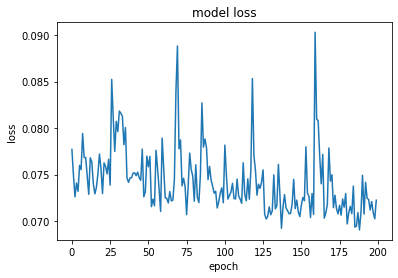

In [186]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [35]:
model.save('output/model_peak_' + str(int(time.time())))

NameError: name 'model' is not defined

In [12]:
new_model = tf.keras.models.load_model('output/model_peak_1664978690/')
new_model.summary()

Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_115 (InputLayer)         [(None, 120, 4)]     0           []                               
                                                                                                  
 lstm_112 (LSTM)                (None, 120, 150)     93000       ['input_115[0][0]']              
                                                                                                  
 lstm_113 (LSTM)                (None, 120, 50)      40200       ['lstm_112[0][0]']               
                                                                                                  
 lstm_114 (LSTM)                [(None, 20),         5680        ['lstm_113[0][0]']               
                                 (None, 20),                                               

In [36]:
scores = new_model.evaluate([ mats['test'][0], mats['test'][1], mats['test'][2]], mats['test'][3], verbose=1)
print(scores)

26/26 [==============================] - 1s 32ms/step - loss: 0.2458 - GlobalOut_loss: 0.0416 - AuxRnnOut_loss: 0.2042 - GlobalOut_accuracy: 0.9463 - AuxRnnOut_accuracy: 0.7441
[0.24577192962169647, 0.04158557206392288, 0.2041863352060318, 0.9463170766830444, 0.7440699338912964]


In [22]:
pre_raw = new_model.predict([ mats['test'][0], mats['test'][1], mats['test'][2]])

26/26 [==============================] - 1s 32ms/step


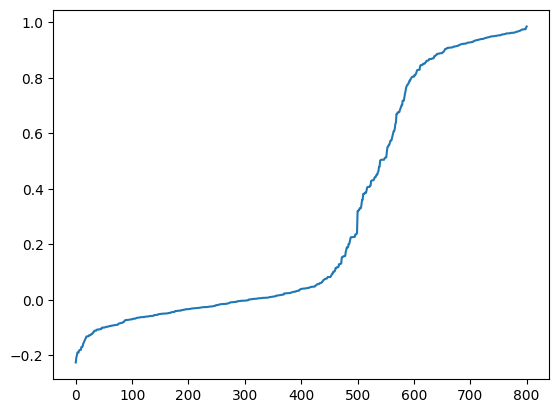

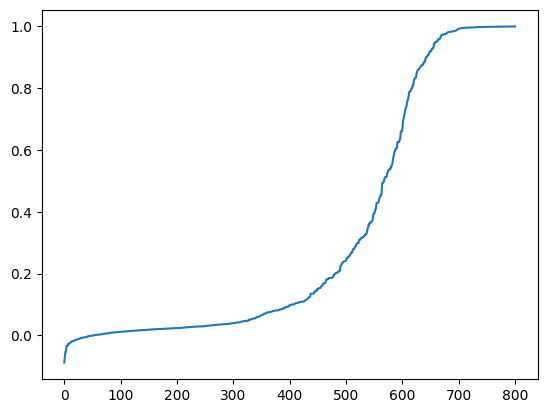

In [26]:
plt.plot(sorted(pre_raw[0]))
plt.show()

plt.plot(sorted(pre_raw[1]))
plt.show()

In [99]:
vis = test.copy().reset_index()
vis['prediction'] = vis.apply(lambda x: pre_raw[1][x.name][0], axis=1)
vis


,index,x,y,norm,smooth,grad1,grad2,maxima,minima,maxval,...,minvalnorm,maxvalstats,minvalstats,maximastats,minimastats,stats,fft,fftr,ffti,prediction
0,554,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[22, 59, 94]","[32, 84]","[0.0009833128946874514, 0.7895711930180207, 0....",...,"[1.0, 0.0]","[0.025, 0.33368503136657957, 0.332982006374606...","[0.016666666666666666, 0.5, 0.5, 0.0, -2.0]","[0.025, 58.333333333333336, 1296.3333333333333...","[0.016666666666666666, 58.0, 1352.0, 0.0, -2.0]","[1.0, 0.053544022502820594, 0.0266807456788889...","[(2094977.2789611816+0j), (-2060916.3090807477...","[2094977.2789611816, -2060916.3090807477, 1977...","[0.0, -72103.10235127185, 139425.21609390705, ...",0.011208
1,6790,"[5141.40087890625, 5420.15625, 5265.3999023437...",0,"[0.17113434098219263, 0.19037576560144262, 0.1...","[0.18446971085761812, 0.18609142771186882, 0.1...","[0.0016217168542506932, 0.0027648005956009553,...","[0.001143083741350262, 0.0012693831737461275, ...","[14, 41, 54, 61, 70, 82]","[21, 47, 57, 64, 75, 118]","[0.3839979398458901, 0.5686753391297039, 0.721...",...,"[0.39706303388921316, 0.6269997037984698, 0.96...","[0.05, 0.6128897421914586, 0.13199849223315666...","[0.05, 0.6610481343295556, 0.16303372495323248...","[0.05, 53.666666666666664, 571.4666666666667, ...","[0.05, 63.666666666666664, 1044.6666666666667,...","[1.0, 0.43969019627604194, 0.06499082792282337...","[(1083720.6657714844+0j), (-277124.8255713013+...","[1083720.6657714844, -277124.8255713013, -7925...","[0.0, 37183.51029393122, -115461.91128317683, ...",0.182053
2,3101,"[368487.3125, 600975.375, 613848.75, 384338.12...",0,"[0.5974395439202439, 0.9788788663610364, 1.0, ...","[0.8319867978245763, 0.7965034673229605, 0.699...","[-0.035483330501615784, -0.06621310672235037, ...","[-0.030729776220734584, -0.04063354637815711, ...","[12, 26, 45, 60, 91, 104, 112]","[8, 24, 42, 53, 83, 100, 105, 114]","[0.0820711181678938, 0.016991601530328995, 0.0...",...,"[1.0, 0.2490184342500326, 0.14859111949661605,...","[0.058333333333333334, 0.23447544610964693, 0....","[0.06666666666666667, 0.19254189970575933, 0.1...","[0.058333333333333334, 64.28571428571429, 1526...","[0.06666666666666667, 66.125, 1591.83928571428...","[1.0, 0.04431570573941492, 0.01864765644549571...","[(3691468.7846679688+0j), (2369462.2086801967-...","[3691468.7846679688, 2369462.2086801967, 22502...","[0.0, -653733.5560525613, -808276.8063441955, ...",0.001373
3,7058,"[2034.3778076171875, 2101.89990234375, 1944.21...",0,"[0.04816133807856478, 0.05685535631123064, 0.0...","[0.05029522667633676, 0.05165679694675008, 0.0...","[0.0013615702704133162, 0.0018721677822134929,...","[0.0005105975118001767, 0.0006629152220143462,...","[6, 16, 31, 37, 46, 70, 91, 105, 110]","[10, 26, 32, 38, 54, 80, 98, 107]","[0.06644798163936232, 0.14836647864245858, 0.0...",...,"[0.0, 0.019224633313849385, 0.0450254686182742...","[0.075, 0.4254400727907248, 0.1927395064878614...","[0.06666666666666667, 0.2565005203659583, 0.11...","[0.075, 56.888888888888886, 1489.6111111111113...","[0.06666666666666667, 55.625, 1265.69642857142...","[1.0, 0.3156888775623453, 0.059662372367517195...","[(493170.5124511719+0j), (14473.622785827214+1...","[493170.5124511719, 14473.622785827214, -1005....","[0.0, 130267.76488145895, 40606.09080397468, 4...",0.051190
4,2605,"[2874.15576171875, 1775.1419677734375, 2108.60...",1,"[0.15564651451640038, 0.06084230705628668, 0.0...","[0.09004605388965074, 0.08875166845974519, 0.0...","[-0.0012943854299055507, -0.001753611152370028...","[-0.00045922572246447774, -0.00014689822298311...","[8, 26, 39, 49, 60, 68, 78, 93, 108]","[3, 15, 32, 45, 54, 67, 73, 85, 102, 115]","[0.12235140075201688, 0.12521036178841644, 0.1...",...,"[0.2662089383876496, 0.0, 0.5570929804973739, ...","[0

In [100]:
pred_min = -10.0
pred_max = 0.2

features = vis.loc[(vis['prediction'] > pred_min) & ( vis['prediction'] < pred_max)]

features


,index,x,y,norm,smooth,grad1,grad2,maxima,minima,maxval,...,minvalnorm,maxvalstats,minvalstats,maximastats,minimastats,stats,fft,fftr,ffti,prediction
0,554,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[22, 59, 94]","[32, 84]","[0.0009833128946874514, 0.7895711930180207, 0....",...,"[1.0, 0.0]","[0.025, 0.33368503136657957, 0.332982006374606...","[0.016666666666666666, 0.5, 0.5, 0.0, -2.0]","[0.025, 58.333333333333336, 1296.3333333333333...","[0.016666666666666666, 58.0, 1352.0, 0.0, -2.0]","[1.0, 0.053544022502820594, 0.0266807456788889...","[(2094977.2789611816+0j), (-2060916.3090807477...","[2094977.2789611816, -2060916.3090807477, 1977...","[0.0, -72103.10235127185, 139425.21609390705, ...",0.011208
1,6790,"[5141.40087890625, 5420.15625, 5265.3999023437...",0,"[0.17113434098219263, 0.19037576560144262, 0.1...","[0.18446971085761812, 0.18609142771186882, 0.1...","[0.0016217168542506932, 0.0027648005956009553,...","[0.001143083741350262, 0.0012693831737461275, ...","[14, 41, 54, 61, 70, 82]","[21, 47, 57, 64, 75, 118]","[0.3839979398458901, 0.5686753391297039, 0.721...",...,"[0.39706303388921316, 0.6269997037984698, 0.96...","[0.05, 0.6128897421914586, 0.13199849223315666...","[0.05, 0.6610481343295556, 0.16303372495323248...","[0.05, 53.666666666666664, 571.4666666666667, ...","[0.05, 63.666666666666664, 1044.6666666666667,...","[1.0, 0.43969019627604194, 0.06499082792282337...","[(1083720.6657714844+0j), (-277124.8255713013+...","[1083720.6657714844, -277124.8255713013, -7925...","[0.0, 37183.51029393122, -115461.91128317683, ...",0.182053
2,3101,"[368487.3125, 600975.375, 613848.75, 384338.12...",0,"[0.5974395439202439, 0.9788788663610364, 1.0, ...","[0.8319867978245763, 0.7965034673229605, 0.699...","[-0.035483330501615784, -0.06621310672235037, ...","[-0.030729776220734584, -0.04063354637815711, ...","[12, 26, 45, 60, 91, 104, 112]","[8, 24, 42, 53, 83, 100, 105, 114]","[0.0820711181678938, 0.016991601530328995, 0.0...",...,"[1.0, 0.2490184342500326, 0.14859111949661605,...","[0.058333333333333334, 0.23447544610964693, 0....","[0.06666666666666667, 0.19254189970575933, 0.1...","[0.058333333333333334, 64.28571428571429, 1526...","[0.06666666666666667, 66.125, 1591.83928571428...","[1.0, 0.04431570573941492, 0.01864765644549571...","[(3691468.7846679688+0j), (2369462.2086801967-...","[3691468.7846679688, 2369462.2086801967, 22502...","[0.0, -653733.5560525613, -808276.8063441955, ...",0.001373
3,7058,"[2034.3778076171875, 2101.89990234375, 1944.21...",0,"[0.04816133807856478, 0.05685535631123064, 0.0...","[0.05029522667633676, 0.05165679694675008, 0.0...","[0.0013615702704133162, 0.0018721677822134929,...","[0.0005105975118001767, 0.0006629152220143462,...","[6, 16, 31, 37, 46, 70, 91, 105, 110]","[10, 26, 32, 38, 54, 80, 98, 107]","[0.06644798163936232, 0.14836647864245858, 0.0...",...,"[0.0, 0.019224633313849385, 0.0450254686182742...","[0.075, 0.4254400727907248, 0.1927395064878614...","[0.06666666666666667, 0.2565005203659583, 0.11...","[0.075, 56.888888888888886, 1489.6111111111113...","[0.06666666666666667, 55.625, 1265.69642857142...","[1.0, 0.3156888775623453, 0.059662372367517195...","[(493170.5124511719+0j), (14473.622785827214+1...","[493170.5124511719, 14473.622785827214, -1005....","[0.0, 130267.76488145895, 40606.09080397468, 4...",0.051190
6,2166,"[0.0, 0.0, 411.1953430175781, 0.0, 0.0, 0.0, 0...",0,"[0.0, 0.0, 0.008275639304016475, 0.0, 0.0, 0.0...","[0.002166590497654965, 0.0020689098260041183, ...","[-9.768067165084665e-05, -0.000176705995038340...","[-7.902532338749423e-05, -9.411781716852968e-0...","[34, 59, 90, 108]","[18, 38, 70, 100]","[0.004094720827107893, 0.4431429982311191, 0.8...",...,"[0.0, 0.009482143943767136, 0.0, 1.0]","[0.03333333333333333, 0.42980048446118035, 0.1...","[0.03

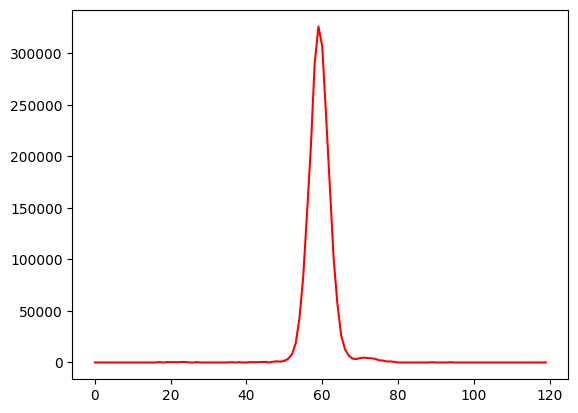

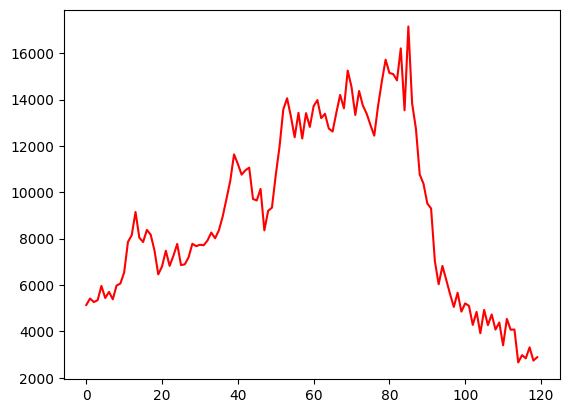

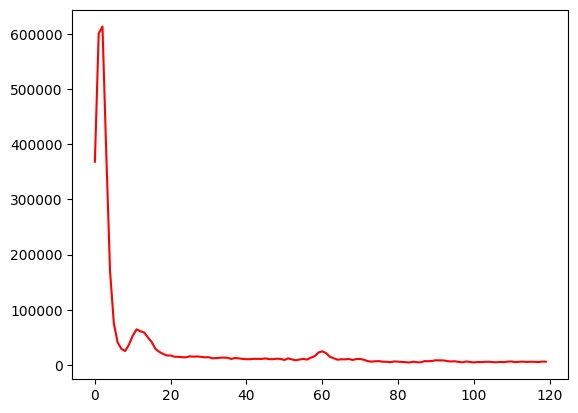

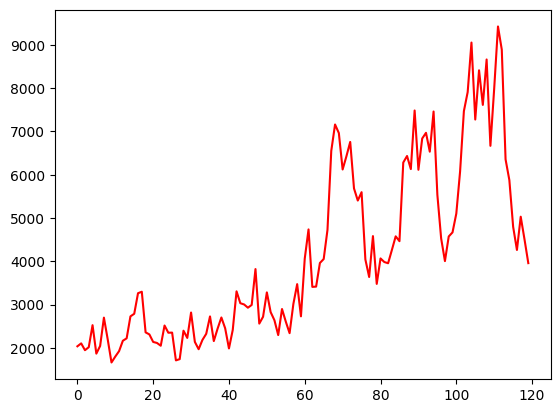

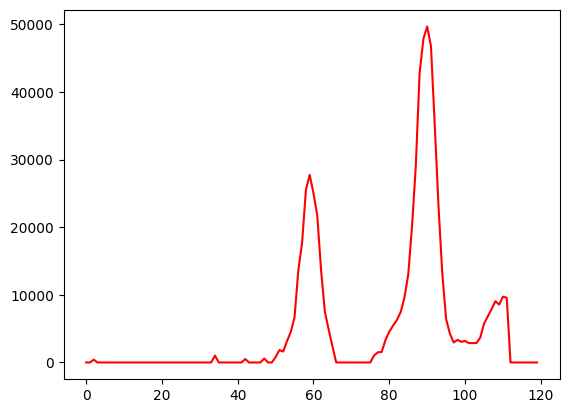

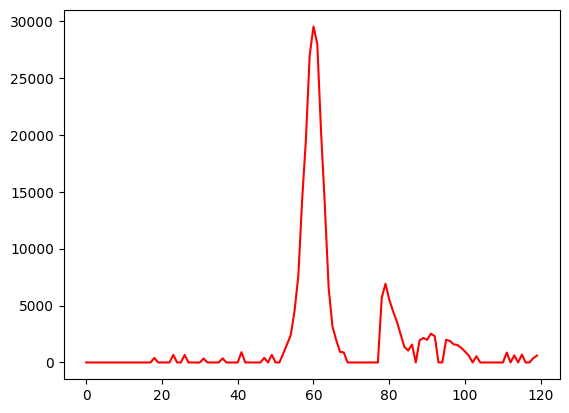

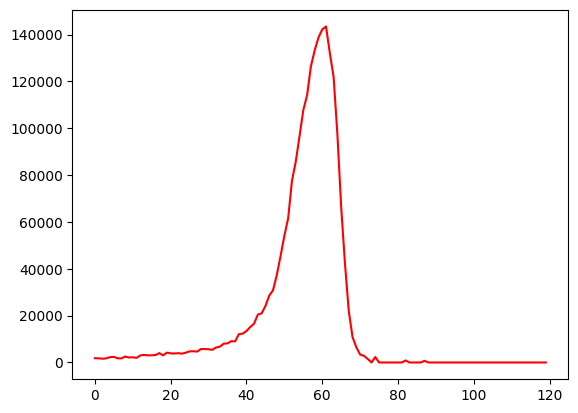

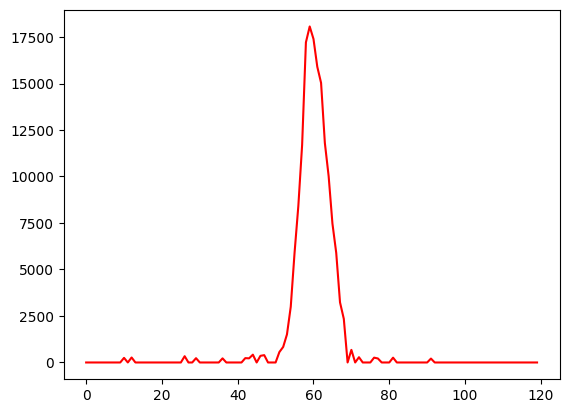

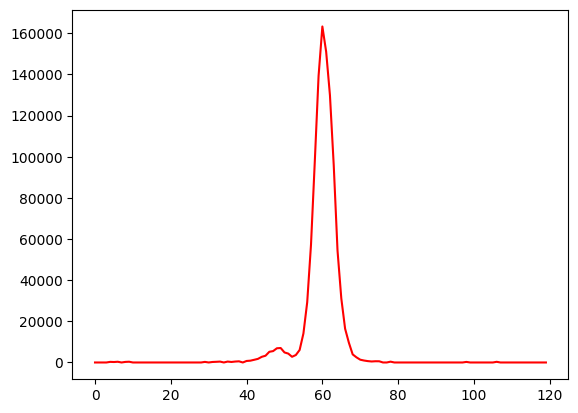

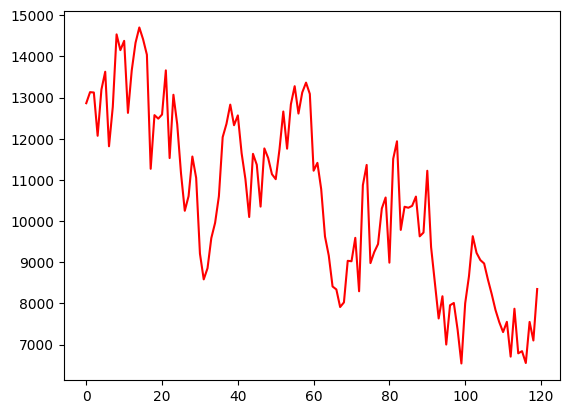

In [102]:
for index, row in list(features.iterrows())[:10]:

    color = 'green' if row['y'] == 1 else 'red'

    plt.plot(row['x'], color = color)
    plt.show()

In [34]:
'''
fp = 0
tp = 0
fn = 0
tn = 0

cpt =0

for y_pred in pre:

    y_ref = list(mats['test'][3])[cpt]
    intensity = list(test[0])[cpt]

    if int(y_pred) != int(y_ref):

        if y_pred == 1:
            fp += 1
            plt.title( 'FP ' + str(list(test['mz'])[cpt]) + ' / '+ str(list(test['rt'])[cpt]) )
        else:
            fn += 1
            plt.title( 'FN ' + str(list(test['mz'])[cpt]) + ' / '+ str(list(test['rt'])[cpt]) )


        color = 'green' if y_pred == 1 else 'red'
        plt.plot(intensity , color = color)
        plt.show()

    else:
        if y_pred == 1:
            tp +=1
            plt.title( 'TP ' + str(list(test['mz'])[cpt]) + ' / '+ str(list(test['rt'])[cpt]) )
        else:
            tn +=1
            plt.title( 'TN ' + str(list(test['mz'])[cpt]) + ' / '+ str(list(test['rt'])[cpt]) )



        color = 'green' if y_pred == 1 else 'red'
        plt.plot(intensity , color = color)
        plt.show()


    cpt +=1

    total = len( mats['test'][0])
false =  tn + fp
print('Predicted Features: ', total)
print('False Predictions: ', false)
print('% Good: ', (total-false)/total*100)
print('\n')

print('TP', tp)
print('TN', tn)
print('FP', fp)
print('FN', fn)
print('\n')

print('Precision: ', (100 * tp)/ (tp+fp) )
print('Recall: ', (100 * tp/ (tp+fn) ))
print('\n')

'''

"\nfp = 0\ntp = 0\nfn = 0\ntn = 0\n\ncpt =0\n\nfor y_pred in pre:\n\n    y_ref = list(mats['test'][3])[cpt]\n    intensity = list(test[0])[cpt]\n\n    if int(y_pred) != int(y_ref):\n\n        if y_pred == 1:\n            fp += 1\n            plt.title( 'FP ' + str(list(test['mz'])[cpt]) + ' / '+ str(list(test['rt'])[cpt]) )\n        else:\n            fn += 1\n            plt.title( 'FN ' + str(list(test['mz'])[cpt]) + ' / '+ str(list(test['rt'])[cpt]) )\n\n\n        color = 'green' if y_pred == 1 else 'red'\n        plt.plot(intensity , color = color)\n        plt.show()\n\n    else:\n        if y_pred == 1:\n            tp +=1\n            plt.title( 'TP ' + str(list(test['mz'])[cpt]) + ' / '+ str(list(test['rt'])[cpt]) )\n        else:\n            tn +=1\n            plt.title( 'TN ' + str(list(test['mz'])[cpt]) + ' / '+ str(list(test['rt'])[cpt]) )\n\n\n\n        color = 'green' if y_pred == 1 else 'red'\n        plt.plot(intensity , color = color)\n        plt.show()\n\n\n    cpt

In [31]:
test

,x,y,norm,smooth,grad1,grad2,maxima,minima,maxval,minval,maxvalnorm,minvalnorm,maxvalstats,minvalstats,maximastats,minimastats,stats,fft,fftr,ffti
554,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[22, 59, 94]","[32, 84]","[0.0009833128946874514, 0.7895711930180207, 0....","[1.9010413877484245e-05, 0.0]","[0.0010550940997387807, 1.0, 0.0]","[1.0, 0.0]","[0.025, 0.33368503136657957, 0.332982006374606...","[0.016666666666666666, 0.5, 0.5, 0.0, -2.0]","[0.025, 58.333333333333336, 1296.3333333333333...","[0.016666666666666666, 58.0, 1352.0, 0.0, -2.0]","[1.0, 0.053544022502820594, 0.0266807456788889...","[(2094977.2789611816+0j), (-2060916.3090807477...","[2094977.2789611816, -2060916.3090807477, 1977...","[0.0, -72103.10235127185, 139425.21609390705, ..."
6790,"[5141.40087890625, 5420.15625, 5265.3999023437...",0,"[0.17113434098219263, 0.19037576560144262, 0.1...","[0.18446971085761812, 0.18609142771186882, 0.1...","[0.0016217168542506932, 0.0027648005956009553,...","[0.001143083741350262, 0.0012693831737461275, ...","[14, 41, 54, 61, 70, 82]","[21, 47, 57, 64, 75, 118]","[0.3839979398458901, 0.5686753391297039, 0.721...","[0.3063874571897404, 0.4726178311149562, 0.714...","[0.0, 0.38360540751869704, 0.7002151099318081,...","[0.39706303388921316, 0.6269997037984698, 0.96...","[0.05, 0.6128897421914586, 0.13199849223315666...","[0.05, 0.6610481343295556, 0.16303372495323248...","[0.05, 53.666666666666664, 571.4666666666667, ...","[0.05, 63.666666666666664, 1044.6666666666667,...","[1.0, 0.43969019627604194, 0.06499082792282337...","[(1083720.6657714844+0j), (-277124.8255713013+...","[1083720.6657714844, -277124.8255713013, -7925...","[0.0, 37183.51029393122, -115461.91128317683, ..."
3101,"[368487.3125, 600975.375, 613848.75, 384338.12...",0,"[0.5974395439202439, 0.9788788663610364, 1.0, ...","[0.8319867978245763, 0.7965034673229605, 0.699...","[-0.035483330501615784, -0.06621310672235037, ...","[-0.030729776220734584, -0.04063354637815711, ...","[12, 26, 45, 60, 91, 104, 112]","[8, 24, 42, 53, 83, 100, 105, 114]","[0.0820711181678938, 0.016991601530328995, 0.0...","[0.06388264616772829, 0.01681787529466204, 0.0...","[1.0, 0.1927753210417177, 0.11501930400634709,...","[1.0, 0.2490184342500326, 0.14859111949661605,...","[0.058333333333333334, 0.23447544610964693, 0....","[0.06666666666666667, 0.19254189970575933, 0.1...","[0.058333333333333334, 64.28571428571429, 1526...","[0.06666666666666667, 66.125, 1591.83928571428...","[1.0, 0.04431570573941492, 0.01864765644549571...","[(3691468.7846679688+0j), (2369462.2086801967-...","[3691468.7846679688, 2369462.2086801967, 22502...","[0.0, -653733.5560525613, -808276.8063441955, ..."
7058,"[2034.3778076171875, 2101.89990234375, 1944.21...",0,"[0.04816133807856478, 0.05685535631123064, 0.0...","[0.05029522667633676, 0.05165679694675008, 0.0...","[0.0013615702704133162, 0.0018721677822134929,...","[0.0005105975118001767, 0.0006629152220143462,...","[6, 16, 31, 37, 46, 70, 91, 105, 110]","[10, 26, 32, 38, 54, 80, 98, 107]","[0.06644798163936232, 0.14836647864245858, 0.0...","[0.04484595823678249, 0.05954492890800582, 0.0...","[0.0, 0.10837468685588855, 0.01773914778461525...","[0.0, 0.019224633313849385, 0.0450254686182742...","[0.075, 0.4254400727907248, 0.1927395064878614...","[0.06666666666666667, 0.2565005203659583, 0.11...","[0.075, 56.888888888888886, 1489.6111111111113...","[0.06666666666666667, 55.625, 1265.69642857142...","[1.0, 0.3156888775623453, 0.059662372367517195...","[(493170.5124511719+0j), (14473.622785827214+1...","[493170.5124511719, 14473.622785827214, -1005....","[0.0, 130267.76488145895, 40606.09080397468, 4..."
2605,"[2874.15576171875, 1775.1419677734375, 2108.60...",1,"[0.15564651451640038, 0.06084230705628668, 0.0...","[0.09004605388965074, 0.0887516684

In [ ]:
total = len( mats['test'][0])
false =  tn + fp
print('Predicted Features: ', total)
print('False Predictions: ', false)
print('% Good: ', (total-false)/total*100)
print('\n')

print('TP', tp)
print('TN', tn)
print('FP', fp)
print('FN', fn)
print('\n')

print('Precision: ', (100 * tp)/ (tp+fp) )
print('Recall: ', (100 * tp/ (tp+fn) ))
print('\n')
